In [1]:
%%capture --no-stderr
!pip install -U langchain langchain-community langchain-openai langchain-cohere pypdf sentence_transformers chromadb shutil openpyxl FlagEmbedding cohere

In [ ]:
%env LLM_API_KEY=替换为自己的Qwen API Key
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1

In [3]:
import langchain, langchain_community, pypdf, sentence_transformers, chromadb, langchain_core, cohere

for module in (langchain, langchain_core, langchain_community, pypdf, sentence_transformers, cohere, chromadb):
    print(f"{module.__name__:<30}{module.__version__}")

/opt/anaconda3/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


/opt/anaconda3/lib/python3.10/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


langchain                     0.2.10
langchain_core                0.2.28
langchain_community           0.2.9
pypdf                         4.3.1
sentence_transformers         3.0.1
cohere                        5.8.0
chromadb                      0.5.4


In [4]:
import os
import pandas as pd

In [5]:
expr_version = 'retrieval_v11_rerank_n_chunks'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

# 读取文档

In [6]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))
documents = loader.load()

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

# 文档切分

In [7]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [8]:
splitted_docs = split_docs(documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


# 检索

In [9]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings

device: cuda


In [10]:
import jieba
import shutil

from tqdm.auto import tqdm
from langchain_community.vectorstores import Chroma
from langchain.retrievers import BM25Retriever, EnsembleRetriever

# 如果已下载，可以替换为本机路径
model_path = 'stevenluo/bge-large-zh-v1.5-ft-v4'
embeddings = get_embeddings(model_path)

persist_directory = os.path.join(expr_dir, 'chroma', 'bge')
shutil.rmtree(persist_directory, ignore_errors=True)
vector_db = Chroma.from_documents(
    splitted_docs,
    embedding=embeddings,
    persist_directory=persist_directory
)
chz_cut_bm25_retriever = BM25Retriever.from_documents(splitted_docs, preprocess_func=lambda text: list(jieba.cut(text)))

def build_get_ensemble_retriver_fn(weights=[0.5, 0.5]):
    return lambda k: EnsembleRetriever(
        retrievers=[vector_db.as_retriever(search_kwargs={'k': k}), chz_cut_bm25_retriever], weights=weights
    )

Building prefix dict from the default dictionary ...


Loading model from cache /tmp/jieba.cache


Loading model cost 0.464 seconds.


Prefix dict has been built successfully.


In [11]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

In [12]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

class HuggingfaceReranker:
    def __init__(self, model_name, model_kwargs: dict):
        self._tokenizer = AutoTokenizer.from_pretrained(model_name)
        self._model = AutoModelForSequenceClassification.from_pretrained(
            model_name, **model_kwargs
        )

    def compute_score(self, pairs):
        if hasattr(self._model, 'compute_score'):
            return self._model.compute_score(pairs)

        with torch.no_grad():
            inputs = self._tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512)
            inputs = inputs.to(self._model.device)
            scores = self._model(**inputs, return_dict=True).logits.view(-1, ).float()
        return scores.cpu().numpy()

In [13]:
def rerank(reranker, query, retrieved_docs, top_k=5, debug=False):
    rerank_scores = reranker.compute_score([[query, doc.page_content] for doc in retrieved_docs])
    triads = [(query, doc, score) for doc, score in zip(retrieved_docs, rerank_scores)]
    triads = sorted(triads, key=lambda triad: triad[-1], reverse=True)
    if debug:
        return triads
    return [triad[1] for triad in triads][:top_k]

In [14]:
from FlagEmbedding import FlagReranker

def get_hit_stat_df(get_retriever_fn, reranker, retirever_multiplier=3):
    hit_stat_data = []
    
    top_k_arr = list(range(1, 9))
    for k in tqdm(top_k_arr):
        retriever = get_retriever_fn(k * retirever_multiplier)
        for idx, row in test_df.iterrows():
            question = row['question']
            true_uuid = row['uuid']
            chunks = retriever.get_relevant_documents(question)[:k * retirever_multiplier]
            chunks = rerank(reranker, question, chunks, top_k=k)
            retrieved_uuids = [doc.metadata['uuid'] for doc in chunks][:k]
    
            hit_stat_data.append({
                'question': question,
                'top_k': k,
                'hit': int(true_uuid in retrieved_uuids)
            })
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

def get_reranker(path):
    """
    屏蔽不同Reranker的差异，封装一个同一个的类获取这些Reranker的示例
    """
    
    if 'bge' in path.lower():
        return FlagReranker(path, use_fp16=True)
    else:
        return HuggingfaceReranker(path, model_kwargs={'trust_remote_code': True, 'torch_dtype': torch.float16, 'device_map': device})

# 预测

In [15]:
from langchain.llms import Ollama

ollama_llm = Ollama(
    model='qwen2:7b-instruct-32k',
    base_url='http://localhost:11434',
    temperature=0
)

In [16]:
def rag(llm, retriever, reranker, query, n_chunks=4, retirever_multiplier=3):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()

    chunks = retriever.invoke(query)[:n_chunks * retirever_multiplier]
    chunks = rerank(reranker, query, chunks, top_k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)

    return llm.invoke(prompt), chunks

In [17]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(llm, retriever, reranker, prediction_df, n_chunks):
    prediction_df = prediction_df.copy()
    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(llm, retriever, reranker, question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }
    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

In [18]:
pred_dfs = {}

In [19]:
n_chunks_arr = range(1, 9)
retirever_multiplier = 3
gte_reranker = get_reranker('AlibabaNLP/gte-multilingual-reranker-base')

In [20]:
get_retriever_fn = build_get_ensemble_retriver_fn(weights=[0.5, 0.5])

In [21]:
for n_chunks in n_chunks_arr:
    if n_chunks in pred_dfs:
        continue

    print(f"n_chunks={n_chunks}")
    retriever = get_retriever_fn(n_chunks * retirever_multiplier)
    pred_dfs[n_chunks] = predict(ollama_llm, retriever, gte_reranker, prediction_df, n_chunks=n_chunks)

n_chunks=1


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=2


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=3


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=4


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=5


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=6


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=7


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=8


  0%|          | 0/100 [00:00<?, ?it/s]

# 评估 

In [22]:
from langchain_openai import ChatOpenAI

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

import time

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()

        retry_count = 3
        result = None
        
        while retry_count > 0:
            try:
                result = judge_llm.invoke(prompt).content
                break
            except:
                time.sleep(4 ** (5 - retry_count))
                retry_count -= 1

        if result is None:
            print(f'question={question}, scoring failed!')
        results.append(result)
        
        time.sleep(1)
    return results

In [23]:
for n_chunks, pred_df in pred_dfs.items():
    pred_df['raw_score'] = evaluate(pred_df)
    print(f"n_chunks={n_chunks}: {pred_df['raw_score'].unique()}")
    pred_df['score'] = (pred_df['raw_score'] == '是').astype(int)
    
    time.sleep(4)

  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=1: ['是' '否']


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=2: ['是' '否']


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=3: ['是' '否']


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=4: ['是' '否']


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=5: ['是' '否']


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=6: ['是' '否']


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=7: ['是' '否']


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=8: ['是' '否']


In [24]:
metrics = []

for n_chunks, pred_df in pred_dfs.items():
    metrics.append({
        'n_chunks': n_chunks,
        'accuracy': pred_df['score'].mean()
    })

In [25]:
metrics_df = pd.DataFrame(metrics)

In [26]:
metrics_df

,n_chunks,accuracy
0,1,0.78
1,2,0.83
2,3,0.88
3,4,0.89
4,5,0.90
5,6,0.91
6,7,0.87
7,8,0.83


<Axes: xlabel='n_chunks', ylabel='accuracy'>

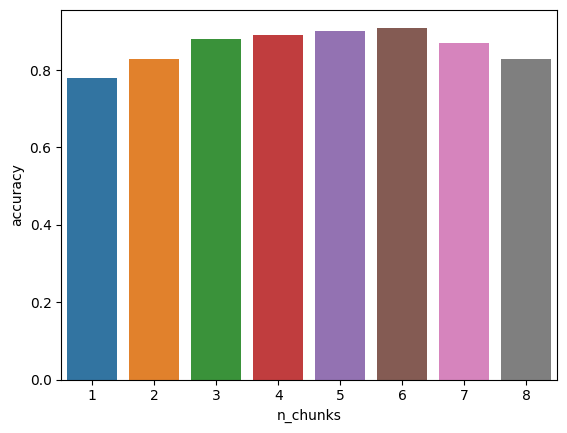

In [27]:
import seaborn as sns

sns.barplot(x='n_chunks', y='accuracy', data=metrics_df)

In [28]:
for n_chunks, pred_df in pred_dfs.items():
    pred_df.to_excel(os.path.join(expr_dir, f'{expr_version}_{n_chunks}_prediction.xlsx'), index=False)

# 结果分析

In [1]:
import pandas as pd

In [2]:
import os

expr_version = 'retrieval_v12_rerank_n_chunks'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

In [7]:
pred_df = pd.read_excel(os.path.join(expr_dir, f'{expr_version}_{6}_prediction.xlsx'))

In [8]:
pred_df.head()

,uuid,question,qa_type,ref_answer,gen_answer,chunks,raw_score,score
0,e73a0c9d-d42b-4350-a4c3-b38bf67c68a5,报告的发布机构是什么？,detailed,中国银行研究院,报告的发布机构是中国银行研究院。,"[Document(metadata={'page': 27, 'source': 'dat...",是,1
1,e73a0c9d-d42b-4350-a4c3-b38bf67c68a5,报告的发布日期是什么时候？,detailed,2023年12月12日,报告的发布日期是2023年12月12日。,"[Document(metadata={'page': 0, 'source': 'data...",是,1
2,e73a0c9d-d42b-4350-a4c3-b38bf67c68a5,2023年全球经济增长有什么特点？,detailed,全球经济增长动力持续回落，各国复苏分化，发达经济体增速放缓，新兴经济体表现稳定。,2023年全球经济增长动力持续减弱，各国复苏分化。发达经济体增速放缓，新兴经济体整体表现稳定...,"[Document(metadata={'page': 2, 'source': 'data...",是,1
3,e73a0c9d-d42b-4350-a4c3-b38bf67c68a5,全球贸易增长情况如何？,detailed,全球贸易增长乏力。,全球贸易增长乏力，各国生产景气度逐渐回落，内需对经济的拉动作用减弱。,"[Document(metadata={'page': 0, 'source': 'data...",是,1
4,e73a0c9d-d42b-4350-a4c3-b38bf67c68a5,展望2024年，全球经济复苏的预期如何？,detailed,全球经济复苏预计将依旧疲软。,预计2024年全球经济复苏将依旧疲软，主要经济体增长态势和货币政策将进一步分化。欧美央行大概...,"[Document(metadata={'page': 2, 'source': 'data...",是,1


In [9]:
pred_df[pred_df['score'] == 0]

,uuid,question,qa_type,ref_answer,gen_answer,chunks,raw_score,score
10,41d95288-441d-4c02-948a-6a3f0f4ef3ba,2023年美元指数的整体走势如何？,detailed,高位震荡后走弱,2023年以来，美元指数始终保持高位，在100-105区间波动，7月初开始震荡走高，之后逐渐...,"[Document(metadata={'page': 30, 'source': 'dat...",否,0
11,1f406690-b478-43cd-96f8-cd77924e300e,全球经济复苏呈现什么特点？,detailed,全球经济复苏不均衡，各国差异大。发达经济体增速放缓，新兴经济体增速基本持平但略有下降。,全球经济复苏呈现疲软和分化的特点。主要表现为：\n\n1. **全球经济增长动力持续回落**...,"[Document(metadata={'page': 2, 'source': 'data...",否,0
24,4bd96918-ce66-4762-a725-8a7e4b543dbe,与2022年底相比，2023年二季度美国非金融企业部门负债率变化了多少个百分点？,detailed,下降了2.4个百分点,2.4个,"[Document(metadata={'page': 6, 'source': 'data...",否,0
30,0a58414c-bf99-493b-b13b-b83c96af2687,世贸组织对2023年全球货物贸易增速的预测值是多少百分点?,detailed,0.9个百分点,世贸组织将2023年全球货物贸易增速预测值下调至0.8%，较之前的预测值减少了0.9个百分点。,"[Document(metadata={'page': 8, 'source': 'data...",否,0
40,1c1d5705-f666-4447-8d61-6c184710e67f,根据英国预算责任办公室的说法，英国民众生活标准何时会开始恢复？,detailed,2024年上半年以后，经济活动有望逐步复苏,预计英国民众以可支配收入衡量的生活标准将在下一财年较疫情前水平低3.5%，但未来经济活动逐步...,"[Document(metadata={'page': 15, 'source': 'dat...",否,0
59,9b9d36c0-27bd-41e9-9dc4-5ae53879a016,2023年，欧元区M3、M2和M1的同比增速情况是否提及？,detailed,提及了，但具体数据未给出,信息片段中未直接提及2023年欧元区M3、M2和M1的具体同比增速情况。提到的是“2023年...,"[Document(metadata={'page': 28, 'source': 'dat...",否,0
67,50f4fb19-9c21-4f0c-babb-2ddb1c33a6d6,公司债的发行规模变化如何？,detailed,上升了2.5%,2023年，美国债券市场的融资规模为71414亿美元，同比下降8.8%。其中，公司债（2.5...,"[Document(metadata={'page': 35, 'source': 'dat...",否,0
76,fd7e1d60-e683-4de9-92b3-59fafe07f643,为什么海湾六国需要进行经济转型?,detailed,过度依赖传统能源限制了工业发展和科技创新动力,海湾六国需要进行经济转型的原因包括：\n\n1. **国际形势变化**：全球能源危机和气候变...,"[Document(metadata={'page': 42, 'source': 'dat...",否,0
77,c6fc6079-0daf-4d6a-bd6e-7d9820012425,沙特的全面绿色倡议包含哪些项目？,detailed,13个可再生能源项目,沙特的全面绿色倡议包括以下关键项目：\n\n1. **NEOM（新未来城）**：发展绿氢和绿...,"[Document(metadata={'page': 43, 'source': 'dat...",否,0


In [12]:
pred_df[pred_df['question'] == '2024年美联储的货币政策预期如何？']

,uuid,question,qa_type,ref_answer,gen_answer,chunks,raw_score,score
96,d4683862-fed6-4867-a255-29db66011c2a,2024年美联储的货币政策预期如何？,large_context,2024年美联储预计将暂停加息，但是利率水平将较长时间维持在高位，预计会维持每月950亿美元...,2024年美联储预计将暂停加息，但利率水平将较长时间维持在高位。美联储将调整资产负债结构，维...,"[Document(metadata={'page': 25, 'source': 'dat...",是,1


In [17]:
def print_case(row):
    print(f"question: {row['question']}")
    print(f"ref_answer:")
    print(row['ref_answer'])
    print()
    print('gen_answer:')
    print(row['gen_answer'])

In [20]:
for idx, row in pred_df[pred_df['score'] == 0].iterrows():
    print_case(row)
    print('\n\n')

question: 2023年美元指数的整体走势如何？
ref_answer:
高位震荡后走弱

gen_answer:
2023年以来，美元指数始终保持高位，在100-105区间波动，7月初开始震荡走高，之后逐渐从高位回落。截至11月15日，美元指数为104.4，较年初上涨0.6%。



question: 全球经济复苏呈现什么特点？
ref_answer:
全球经济复苏不均衡，各国差异大。发达经济体增速放缓，新兴经济体增速基本持平但略有下降。

gen_answer:
全球经济复苏呈现疲软和分化的特点。主要表现为：

1. **全球经济增长动力持续回落**，各国复苏存在较大差异，发达经济体增速明显放缓，新兴经济体整体表现稳定但增长承压。

2. **需求端下行压力可能大于生产端**，高通胀、高利率、高债务背景下，居民家庭资产负债表状况变差，紧缩性货币政策对需求端的影响逐步显现。

3. **各国经济走势将进一步分化**。相较于新兴市场和发展中经济体，发达经济体面临更大的经济增长压力。欧元区和英国的通胀压力较大，美国经济处于下行阶段但“软着陆”概率更大。中国和其他亚太经济体有望逐渐企稳，成为稳定全球经济的重要力量。

4. **需求端可能加速回落**，在高通胀、高利率、高债务背景下，支撑2023年经济增长的需求因素面临加速下降的压力。

5. **一些稳定因素将显现**，如全球供应链和工业生产逐步恢复正常，宏观政策效应释放等，对经济形成托底作用。



question: 与2022年底相比，2023年二季度美国非金融企业部门负债率变化了多少个百分点？
ref_answer:
下降了2.4个百分点

gen_answer:
2.4个



question: 世贸组织对2023年全球货物贸易增速的预测值是多少百分点?
ref_answer:
0.9个百分点

gen_answer:
世贸组织将2023年全球货物贸易增速预测值下调至0.8%，较之前的预测值减少了0.9个百分点。



question: 根据英国预算责任办公室的说法，英国民众生活标准何时会开始恢复？
ref_answer:
2024年上半年以后，经济活动有望逐步复苏

gen_answer:
预计英国民众以可支配收入衡量的生活标准将在下一财年较疫情前水平低3.5%，但未来经济活动逐步复苏后有望恢复